Weather affects every single human on earth for the better or worse, and we've come to rely on weather predictions in order to plan how we spend our day. But how can we predict the weather? In this post we're going to develop a machine learning model with recurrent neural networks to see how well we can predict the weather.

As per previous posts we're going to go through the following steps (typical of any machine learning project):
1. Data exploration & analysis
2. Build a model
3. Train the model
4. Evaluate the model


In [1]:
import pandas as pd
import plotly
import plotly.express as px
from IPython.core.display import HTML
import torch
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Data Exploration & Analysis

We'll be using rainfall records for Newcastle NSW retrieved from the Australian Bureau of Meteorology, this can be downloaded at: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=136&p_display_type=dailyDataFile&p_startYear=&p_c=&p_stn_num=061055

In [2]:
rainfall = pd.read_csv('data/IDCJAC0009_061055_1800_Data.csv')
print(rainfall.head(1))

  Product code  Bureau of Meteorology station number  Year  Month  Day  \
0   IDCJAC0009                                 61055  1862      1    1   

   Rainfall amount (millimetres)  \
0                            0.0   

   Period over which rainfall was measured (days) Quality  
0                                             NaN       Y  


Let's clean it up

In [3]:
rainfall['timestamp'] = pd.to_datetime(rainfall[['Year', 'Month', 'Day']])
rainfall = rainfall.drop(['Product code','Bureau of Meteorology station number','Year','Month','Day','Period over which rainfall was measured (days)'],axis=1)
rainfall = rainfall.rename(columns={"Rainfall amount (millimetres)": "rainfall", "Quality": "quality"})
rainfall.head()

,rainfall,quality,timestamp
0,0.0,Y,1862-01-01
1,0.0,Y,1862-01-02
2,0.0,Y,1862-01-03
3,0.0,Y,1862-01-04
4,0.0,Y,1862-01-05


In [4]:
print(f"First date: {rainfall.timestamp.min()}, last date: {rainfall.timestamp.max()}")

First date: 1862-01-01 00:00:00, last date: 2022-04-07 00:00:00


In [5]:
rainfall = rainfall.dropna(subset=["rainfall"])
rainfall = rainfall.set_index('timestamp')

In [6]:
def generate_time_lags(df, value, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n[value].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

In [7]:
df_gen = generate_time_lags(rainfall,'rainfall', 100)

df_gen

/var/folders/7t/v3b3p3455bq_r5tknrnqgczr0000gn/T/ipykernel_12150/4251947411.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"lag{n}"] = df_n[value].shift(n)
/var/folders/7t/v3b3p3455bq_r5tknrnqgczr0000gn/T/ipykernel_12150/4251947411.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"lag{n}"] = df_n[value].shift(n)


,rainfall,quality,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
timestamp,,,,,,,,,,,,,,,,,,,,,
1862-04-11,1.0,Y,0.8,10.4,1.0,0.8,0.0,7.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1862-04-12,0.0,Y,1.0,0.8,10.4,1.0,0.8,0.0,7.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1862-04-13,12.2,Y,0.0,1.0,0.8,10.4,1.0,0.8,0.0,7.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1862-04-14,1.3,Y,12.2,0.0,1.0,0.8,10.4,1.0,0.8,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1862-04-15,0.0,Y,1.3,12.2,0.0,1.0,0.8,10.4,1.0,0.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-03,0.0,N,0.2,16.8,3.2,6.6,2.0,5.2,0.8,6.4,...,0.0,0.0,0.0,0.0,1.2,2.4,0.0,0.0,0.0,0.2
2022-04-04,0.0,N,0.0,0.2,16.8,3.2,6.6,2.0,5.2,0.8,...,0.0,0.0,0.0,0.0,0.0,1.2,2.4,0.0,0.0,0.0
2022-04-05,0.0,N,0.0,0.0,0.2,16.8,3.2,6.6,2.0,5.2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.2,2.4,0.0,0.0


In [8]:
# # https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

df_features = (
                df_gen
                .assign(day = df_gen.index.day)
                .assign(month = df_gen.index.month)
                .assign(day_of_week = df_gen.index.dayofweek)
                .assign(week_of_year = df_gen.index.week)
              )

/var/folders/7t/v3b3p3455bq_r5tknrnqgczr0000gn/T/ipykernel_12150/3970123276.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  .assign(week_of_year = df_gen.index.week)


In [9]:
df_features['quality'] = df_features['quality'].replace('Y',1)
df_features['quality'] = df_features['quality'].replace('N',0)

In [10]:
# Maintain cylical nature of datetimes to encode them
# You want to preserve the cyclical nature of your inputs. One approach is to cut the datetime variable into four variables: year, month, day, and hour. Then, decompose each of these (except for year) variables in two.
# You create a sine and a cosine facet of each of these three variables (i.e., month, day, hour), which will retain the fact that hour 24 is closer to hour 0 than to hour 21, and that month 12 is closer to month 1 than to month 10.

# Motivation: There are some features that are cyclic by nature. For example the hours of a day or the months in a year. In these cases, the higher values of the variable are closer to the lower values. For example, December (12) is closer to January (1) than to June (6). By applying a cyclical transformation we capture this cycle or proximity between values.
def cyclical_transformer(df, column, period, start_val, drop_original=True):
    df[f"{column}_sin"] = np.sin(2 * np.pi * (df[column] - start_val) / period)
    df[f"{column}_cos"] = np.cos(2 * np.pi * (df[column] - start_val) / period)
    if drop_original:
        df = df.drop(column, axis=1)
    return df

# The period and start values were determined from the min/max of the columns
cyclical_features = {"day": (31,1), "month": (12,1), "day_of_week": (6,0), "week_of_year": (53,1)}
for cyclical_feature, (period, start_val) in cyclical_features.items():
    df_features = cyclical_transformer(df_features, cyclical_feature, period, start_val)



In [11]:
df_features.head()

,rainfall,quality,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,lag99,lag100,day_sin,day_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
1862-04-11,1.0,1,0.8,10.4,1.0,0.8,0.0,7.6,0.0,0.0,...,0.0,0.0,0.897805,-0.440394,1.0,6.123234e-17,-8.660254e-01,-0.5,0.996050,-0.088796
1862-04-12,0.0,1,1.0,0.8,10.4,1.0,0.8,0.0,7.6,0.0,...,0.0,0.0,0.790776,-0.612106,1.0,6.123234e-17,-8.660254e-01,0.5,0.996050,-0.088796
1862-04-13,12.2,1,0.0,1.0,0.8,10.4,1.0,0.8,0.0,7.6,...,0.0,0.0,0.651372,-0.758758,1.0,6.123234e-17,-2.449294e-16,1.0,0.996050,-0.088796
1862-04-14,1.3,1,12.2,0.0,1.0,0.8,10.4,1.0,0.8,0.0,...,0.0,0.0,0.485302,-0.874347,1.0,6.123234e-17,0.000000e+00,1.0,0.978556,-0.205979
1862-04-15,0.0,1,1.3,12.2,0.0,1.0,0.8,10.4,1.0,0.8,...,0.0,0.0,0.299363,-0.954139,1.0,6.123234e-17,8.660254e-01,0.5,0.978556,-0.205979


In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

TEST_RATIO = 0.25

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_validation_test_split(df, target_col,test_ratio):
    validation_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_ratio, shuffle=False)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(df_features, 'rainfall', TEST_RATIO)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_validation_scaled = scaler.transform(y_validation)
y_test_scaled = scaler.transform(y_test)




In [23]:
BATCH_SIZE = 64

train = torch.utils.data.TensorDataset(torch.Tensor(X_train_scaled),torch.Tensor(y_train_scaled))
validation = torch.utils.data.TensorDataset(torch.Tensor(X_validation_scaled),torch.Tensor(y_validation_scaled))
test = torch.utils.data.TensorDataset(torch.Tensor(X_test_scaled),torch.Tensor(y_test_scaled))

train_loader = torch.utils.data.DataLoader(train,batch_size=BATCH_SIZE,shuffle=False, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation,batch_size=BATCH_SIZE,shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=BATCH_SIZE,shuffle=False, drop_last=True)


In [24]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, layer_dimension, output_dimension, dropout_probability):
        super(RNNModel, self).__init__()

        self.hidden_dimension = hidden_dimension
        self.layer_dimension = layer_dimension

        self.rnn = torch.nn.RNN(
            input_size=input_dimension, hidden_size=hidden_dimension, num_layers=layer_dimension, batch_first=True, dropout=dropout_probability
        )
        self.fc = torch.nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # Hidden state
        h0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        out, h0 = self.rnn(x, h0.detach())

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [25]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, layer_dimension, output_dimension, dropout_probability):
        super(LSTMModel, self).__init__()

        self.hidden_dimension = hidden_dimension
        self.layer_dimension = layer_dimension

        self.lstm = torch.nn.LSTM(
            input_dimension, hidden_dimension, layer_dimension, batch_first=True, dropout=dropout_probability
        )
        self.fc = torch.nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # Hidden state
        h0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        # LSTM Cell state
        c0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [26]:
class GRUModel(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, layer_dimension, output_dimension, dropout_probability):
        super(GRUModel, self).__init__()

        self.hidden_dimension = hidden_dimension
        self.layer_dimension = layer_dimension

        self.gru = torch.nn.GRU(
            input_dimension, hidden_dimension, layer_dimension, batch_first=True, dropout=dropout_probability
        )
        self.fc = torch.nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # Hidden state
        h0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        out, h0 = self.gru(x, h0.detach())

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [34]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features])
                y_batch = y_batch
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features])
                    y_val = y_val
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features])
                y_test = y_test
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.detach().numpy())
                values.append(y_test.detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.0013	 Validation loss: 0.0010
[2/100] Training loss: 0.0012	 Validation loss: 0.0010
[3/100] Training loss: 0.0012	 Validation loss: 0.0010
[4/100] Training loss: 0.0012	 Validation loss: 0.0009
[5/100] Training loss: 0.0012	 Validation loss: 0.0009
[6/100] Training loss: 0.0012	 Validation loss: 0.0009
[7/100] Training loss: 0.0011	 Validation loss: 0.0009
[8/100] Training loss: 0.0011	 Validation loss: 0.0009
[9/100] Training loss: 0.0011	 Validation loss: 0.0009
[10/100] Training loss: 0.0011	 Validation loss: 0.0009
[50/100] Training loss: 0.0011	 Validation loss: 0.0009
[100/100] Training loss: 0.0011	 Validation loss: 0.0009


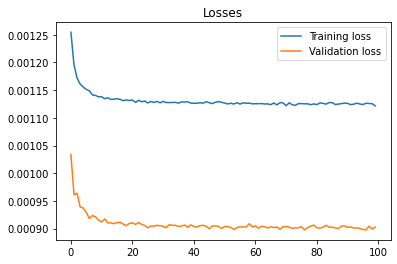

In [93]:
import torch.optim as optim

input_dimension = len(X_train.columns)
output_dimension = 1
hidden_dimension = 64
layer_dimension = 3
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dimension': input_dimension,
                'hidden_dimension' : hidden_dimension,
                'layer_dimension' : layer_dimension,
                'output_dimension' : output_dimension,
                'dropout_probability' : dropout}

model = GRUModel(**model_params)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, validation_loader, n_epochs=n_epochs, n_features=input_dimension)
opt.plot_losses()

In [94]:
predictions, values = opt.evaluate(test_loader, batch_size=64, n_features=input_dimension)

In [95]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)

df_result.head(5)

,value,prediction
timestamp,,
1989-12-22,0.0,1.839836
1989-12-23,0.0,1.065581
1989-12-24,0.0,0.366215
1989-12-25,0.0,0.506618
1989-12-26,0.2,0.383995


In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df, source_col):
    return {'mae' : mean_absolute_error(df[source_col], df.prediction),
            'rmse' : mean_squared_error(df[source_col], df.prediction) ** 0.5,
            'r2' : r2_score(df[source_col], df.prediction)}

result_metrics = calculate_metrics(df_result,'value')

result_metrics

{'mae': 3.3079464, 'rmse': 9.014529897203632, 'r2': 0.05718691344789961}

In [97]:
from sklearn.linear_model import LinearRegression

def build_baseline_model(df, test_ratio, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result

df_baseline = build_baseline_model(df_features, TEST_RATIO, 'rainfall')
baseline_metrics = calculate_metrics(df_baseline,'rainfall')

<AxesSubplot:xlabel='timestamp'>

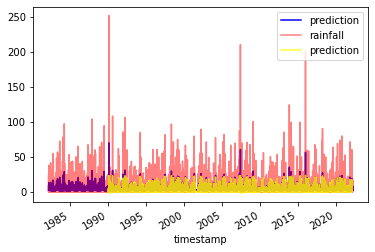

In [98]:
ax = df_baseline.prediction.plot(color='blue',legend=True)

df_baseline.rainfall.plot(color='red', ax=ax, legend=True,alpha=0.5)

df_result.prediction.plot(color='yellow',ax=ax,legend=True, alpha=0.8)